<a href="https://colab.research.google.com/github/tpavan03/Phishing-Detection/blob/main/CaptumExplainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [ ]:
X = df.drop([ 'FILENAME','Domain','TLD','URL', 'Title','label'], axis=1)  # Drop unnecessary columns
y = df['label']
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

all_columns = df.columns.tolist()

numerical_features = [col for col in all_columns if col not in ['FILENAME', 'Domain', 'TLD', 'URL', 'Title', 'label']]

X = df[numerical_features]

scaler = MinMaxScaler()
scaler.fit(X)

X_normalized = scaler.transform(X)

df[numerical_features] = X_normalized

In [ ]:
!pip install captum aix360 torchray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 23.2 MB/s eta 0:00:00
  Created wheel for torchray: filename=torchray-1.0.0.2-py3-none-any.whl size=444010 sha256=c2f0ded9c3e3a0228e9f6a09bad12b3d4f1cc090bf87536afb1275dcd7ddfe9a
  Stored in directory: /root/.cache/pip/wheels/67/89/6f/9f783db1b9c9c2f31323a990f12e156e4f99d9ae15c9a2e96c
Successfully built torchray


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert Pandas DataFrames to NumPy arrays before creating tensors
X_train_tensor = torch.FloatTensor(X_train.values)  # Use .values to get the underlying NumPy array
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Reshape for output
X_test_tensor = torch.FloatTensor(X_test.values)  # Use .values to get the underlying NumPy array

In [ ]:
print(X_train_tensor.shape)

torch.Size([109786, 50])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))
        return x

# Initialize the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

for epoch in range(num_epochs):
    model.train()
    for i in range(num_batches):
        # Get batch data
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_tensor[start:end]
        y_batch = y_train_tensor[start:end]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0000
Epoch [2/5], Loss: 0.0000
Epoch [3/5], Loss: 0.0001
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()  # Get probabilities
    y_pred = (y_pred_probs > 0.5).astype(int)     # Convert to binary predictions

print(y_pred)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]


In [ ]:
outputs = model(X_train_tensor)
print(outputs.shape)

torch.Size([109786, 1])


In [ ]:
from captum.attr import IntegratedGradients
# Extract a single input sample from X_train_tensor
input_tensor = X_train_tensor[0].unsqueeze(0)  # Take the first sample and add batch dimension

target_label = torch.tensor(1)

# Initialize the Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions for the input samples with respect to the target class
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Print attributions and delta for interpretation of values
print('Attributions:', attributions)
print('Delta (convergence check):', delta)

Attributions: tensor([[-1.4564e-01, -3.6309e-02, -0.0000e+00,  2.9774e-01, -6.0493e-03,
         -9.4361e-04, -3.0061e-04, -2.3255e-02,  8.8314e-04, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -6.1620e-02, -3.1435e-03, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.4711e-02,
         -6.5359e-04,  1.4953e-02,  6.2849e-01,  9.8762e-03, -5.7257e-03,
          7.9159e-02, -9.9701e-02,  0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
         -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
         -8.1437e-03, -2.6881e-03, -2.2627e-03,  7.1587e-03,  4.4231e-02,
          0.0000e+00,  0.0000e+00,  7.6693e-03, -8.6310e-04,  1.2812e-01]],
       dtype=torch.float64)
Delta (convergence check): tensor([-0.0275], dtype=torch.float64)


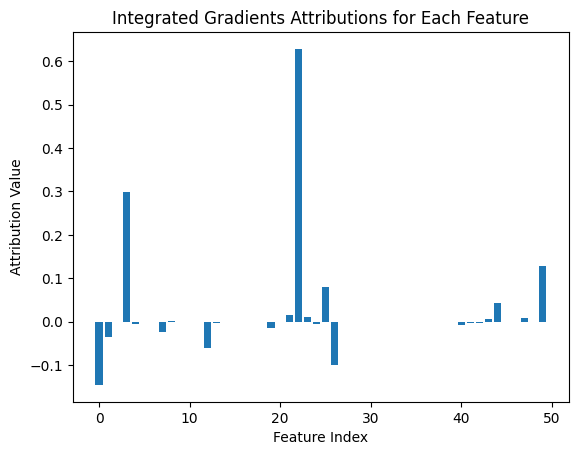

In [ ]:
import matplotlib.pyplot as plt

# Convert attributions to numpy for visualization
attributions_np = attributions.squeeze().detach().numpy()

# Plot the attributions for each feature
plt.bar(range(len(attributions_np)), attributions_np)
plt.xlabel('Feature Index')
plt.ylabel('Attribution Value')
plt.title('Integrated Gradients Attributions for Each Feature')
plt.show()

In [ ]:
# Find the index of the feature with the largest attribution value
dominant_feature_index = attributions_np.argmax()
dominant_feature_value = attributions_np[dominant_feature_index]

# Print the index and value of the most important feature
print(f"The dominant feature is at index {dominant_feature_index} with an attribution value of {dominant_feature_value}")

The dominant feature is at index 22 with an attribution value of 0.6284908049173752


In [ ]:
dominant_feature_index = 22  # Index of the dominant feature
dominant_feature_name = X_train.columns[dominant_feature_index]  # Get the column name

# Print the dominant feature name and its attribution value
print(f"The dominant feature is '{dominant_feature_name}' at index {dominant_feature_index} with an attribution value of {attributions_np[dominant_feature_index]}")

The dominant feature is 'LineOfCode' at index 22 with an attribution value of 0.6284908049173752


In [ ]:
# Average attributions across the batch
mean_attributions = attributions_np.mean(axis=0)

# Identify the top 5 most important features
important_features_indices = mean_attributions.argsort()[-5:][::-1]  # Get indices of top 5 features
print(f"Top 5 most important features: {important_features_indices}")

Top 5 most important features: [22  3 49 25 44]


In [ ]:
important_feature_names = [X_train.columns[i] for i in important_features_indices]
print(f"Top 5 most important features (names): {important_feature_names}")

Top 5 most important features (names): ['LineOfCode', 'URLSimilarityIndex', 'NoOfExternalRef', 'DomainTitleMatchScore', 'NoOfImage']


# **FAITHFULNESS CHECK**
We will check the faithfulness of the model by removing the top 5 attributes with highest integrated gradients and check the new accuracy of model

In [ ]:
# Create a copy of the test dataset
X_test_ablation = X_test_tensor.clone()
for idx in important_features_indices:
    X_test_ablation[:, idx] = 0  # Set the important features to zero


In [ ]:
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)  # Reshape for output

In [ ]:
# Define a loss function and evaluation metric
criterion = torch.nn.BCELoss()
correct = 0
total = 0

# Perform inference on the  data after feature removal
with torch.no_grad():
    outputs = model(X_test_ablation)
    predicted = (outputs > 0.5).float()  # Binary classification (threshold at 0.5)

    # Calculate accuracy
    correct += (predicted == y_test_tensor).sum().item()
    total += y_test_tensor.size(0)

accuracy_after_ablation = correct / total
print(f"Accuracy after ablating top features: {accuracy_after_ablation}")

Accuracy after ablating top features: 0.654467397772677


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

with torch.no_grad():
    outputs = model(X_test_ablation)
    predicted = (outputs > 0.5).float()  # Binary classification (threshold at 0.5)

    # Convert predicted and true labels to numpy for metric calculations
    predicted_np = predicted.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate accuracy and other metrics
    accuracy_after_ablation = accuracy_score(y_test_np, predicted_np)
    precision_after_ablation = precision_score(y_test_np, predicted_np)
    recall_after_ablation = recall_score(y_test_np, predicted_np)
    f1_after_ablation = f1_score(y_test_np, predicted_np)

print(f"Accuracy after ablating top features: {accuracy_after_ablation:.4f}")
print(f"Precision after ablating top features: {precision_after_ablation:.4f}")
print(f"Recall after ablating top features: {recall_after_ablation:.4f}")
print(f"F1 Score after ablating top features: {f1_after_ablation:.4f}")

Accuracy after ablating top features: 0.6545
Precision after ablating top features: 1.0000
Recall after ablating top features: 0.4017
F1 Score after ablating top features: 0.5732


In [ ]:
with torch.no_grad():
    outputs_original = model(X_test_tensor)
    predicted_original = (outputs_original > 0.5).float()

    correct_original = (predicted_original == y_test_tensor).sum().item()
    accuracy_original = correct_original / total
    print(f"Original accuracy: {accuracy_original}")

# Compare the accuracies
performance_drop = accuracy_original - accuracy_after_ablation
print(f"Performance drop after feature ablation: {performance_drop}")

Original accuracy: 0.9991711298138231
Performance drop after feature ablation: 0.344703732041146


# **ROBUSTNESS** **CHECK**

In [ ]:
# Add small Gaussian noise to disturb the input
noise = torch.normal(mean=0, std=0.01, size=input_tensor.shape)  # Small noise with std = 0.01
input_tensor_perturbed = input_tensor + noise

# Make sure the perturbed input is still valid (e.g., within the expected range)
input_tensor_perturbed = torch.clamp(input_tensor_perturbed, 0, 1)  # If the input range is [0, 1]

In [ ]:

# Ensure the model is in eval mode
model.eval()

# Disturbrb the input by adding small Gaussian noise
noise = torch.normal(mean=0, std=0.01, size=input_tensor.shape)  # Small noise with std = 0.01
input_tensor_perturbed = input_tensor + noise

input_tensor_perturbed = torch.clamp(input_tensor_perturbed, 0, 1)

# Compute attributions for the disturbed inputs
attributions_perturbed, _ = ig.attribute(input_tensor_perturbed, return_convergence_delta=True)

# Convert attributions to numpy for comparison
attributions_perturbed_np = attributions_perturbed.detach().numpy()

# Print or visualize the perturbed attributions
print("Perturbed Attributions: ", attributions_perturbed_np)

Perturbed Attributions:  [[-3.09629938e-02 -1.48874681e-02 -3.19710828e-05  2.11075023e-03
  -3.50504068e-02 -8.77012159e-03 -1.74692962e-03 -4.19208683e-02
  -7.10813561e-03 -2.61756997e-05 -0.00000000e+00 -6.37247772e-05
  -2.31510247e-02 -1.74461975e-02 -6.67704578e-05 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -2.09850433e-05 -7.43993528e-02
  -3.14097926e-03  5.43474939e-02  5.95153295e-03  6.33743126e-04
  -2.68877071e-02  9.35139826e-03  1.24497837e-03  1.33912354e-05
   0.00000000e+00 -1.63773990e-05 -1.50724956e-03 -0.00000000e+00
   8.22696081e-04 -1.24183905e-05  0.00000000e+00  1.24208292e-05
   1.02046883e-03  0.00000000e+00  4.39580070e-06 -0.00000000e+00
  -3.49883699e-02 -4.42602514e-03 -9.87767999e-03  3.13079856e-02
   2.50151279e-02  0.00000000e+00  1.38900583e-04  3.53979063e-02
   4.66789607e-03  2.29423920e-02]]


In [ ]:
import numpy as np

# Compute the L2 distance (Euclidean distance) between the original and disturbed attributions
l2_distance = np.linalg.norm(attributions_np - attributions_perturbed_np)

# Print the L2 distance to measure how much the attributions change
print(f"L2 distance between original and perturbed attributions: {l2_distance}")

L2 distance between original and perturbed attributions: 0.7251753117164966


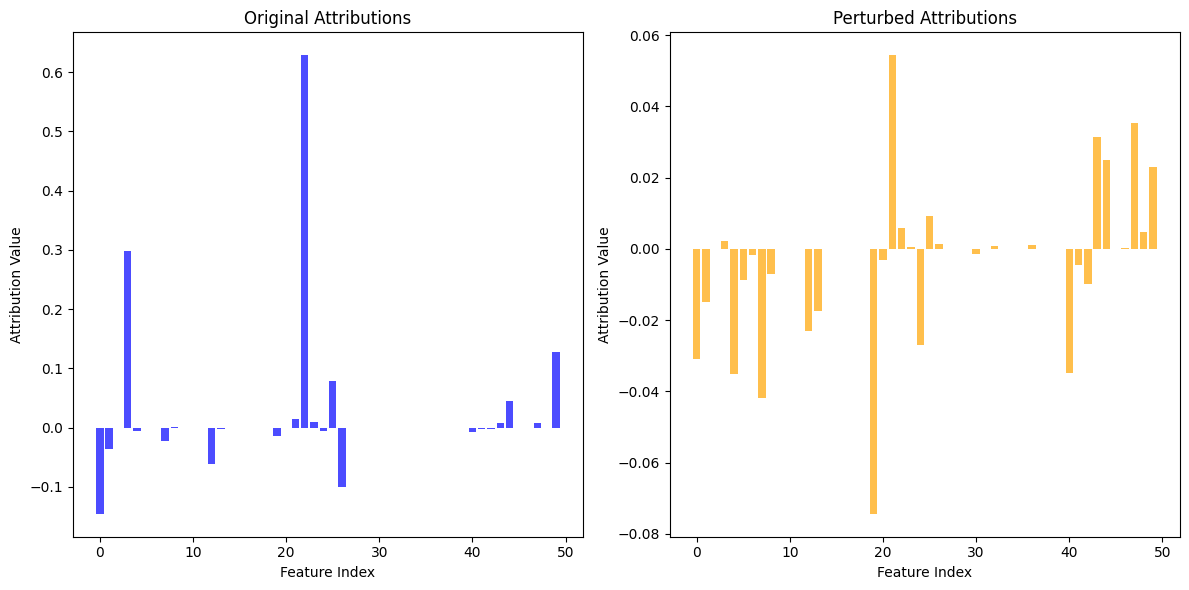

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Subplot 1: Original attributions
plt.subplot(1, 2, 1)
plt.bar(range(len(attributions_np[0])), attributions_np[0], alpha=0.7, color='blue')
plt.xlabel('Feature Index')
plt.ylabel('Attribution Value')
plt.title('Original Attributions')

# Subplot 2: Disturbed attributions
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.bar(range(len(attributions_perturbed_np[0])), attributions_perturbed_np[0], alpha=0.7, color='orange')
plt.xlabel('Feature Index')
plt.ylabel('Attribution Value')
plt.title('Perturbed Attributions')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
criterion = torch.nn.BCELoss()
correct = 0
total = 0

with torch.no_grad():
    outputs = model(input_tensor_perturbed)
    predicted = (outputs > 0.5).float()

    correct += (predicted == y_test_tensor).sum().item()
    total += y_test_tensor.size(0)
accuracy_after_ablation = correct / total
print(f"Accuracy after perturbating top features: {accuracy_after_ablation}")

Accuracy after perturbating top features: 0.4224475048882088
